In [388]:
import numpy as np
import pandas as pd
import cooler
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import numpy as np
from numpy.random import uniform

In [516]:
ep_long = pd.read_csv('/data2/josh/ep/activePairixAll.csv')

In [517]:
# Add chromatin labels

# Import $chipname chip-seq peaks - mm10
chipfile = '/data2/josh/chipseq/Esrrb/esrrb_mm10.bed'
chipname = 'Esrrb'
chip = pd.read_csv(chipfile, delimiter='\t', header=None)
chip.columns = ['chr', 'start', 'end', 'id', 'strength']

# Label promoters as ChIP-seq overlapping or not (new column)
promoters_chip_list = []
counter = 0
for idx, row in ep_long.iterrows():
    chrom = row.p_chr
    p_start = row.p_start
    p_end = row.p_end
    chip_matches = chip[(chip['chr'] == chrom) & ((chip['start'] < p_start) & (chip['end'] > p_start) |
                                                  (chip['start'] < p_end) & (chip['end'] > p_end))]
    if chip_matches.empty:
        promoters_chip_list.append(False)
    else:
        promoters_chip_list.append(True)
    if counter % 1000 == 0:
        print(float(counter)/39277)
    counter += 1

ep_long['p_chip'] = ''
ep_long['p_chip'] = promoters_chip_list

0.0


In [518]:
ep_long[ep_long['p_chip']==True].shape[0]

42

In [519]:
# Label enhancers as ChIP-seq overlapping or not (new column)
enhancers_chip_list = []
counter = 0
for idx, row in ep_long.iterrows():
    chrom = row.e_chr
    e_start = row.e_start
    e_end = row.e_end
    
    chip_matches = chip[(chip['chr'] == chrom) & ((chip['start'] < e_start) & (chip['end'] > e_start) |
                                                  (chip['start'] < e_end) & (chip['end'] > e_end))]
    if chip_matches.empty:
        enhancers_chip_list.append(False)
    else:
        enhancers_chip_list.append(True)
    if counter % 1000 == 0:
        print(float(counter)/39277)
    counter += 1

ep_long['e_chip'] = ''
ep_long['e_chip'] = enhancers_chip_list

0.0


In [520]:
ep_long[ep_long['e_chip']==True].shape[0]

71

In [521]:
# Import and define chromosomes df - mm10
c = cooler.Cooler('/data2/josh/stan/merge_res200.cool')
chrs = c.chroms()[:]
chrs['name'] = chrs['name'].str.replace('chr', '')
chrs = chrs.set_index('name')
chrs.index.names = ['chrom']
chrs.head()

,length
chrom,
1,195471971
2,182113224
3,160039680
4,156508116
5,151834684


In [522]:
# Import TAD list
tads = pd.read_csv('/data2/josh/tads/TAD_mm10.csv', delimiter='\t')
tads['chrom'] = tads['chrom'].str.replace('chr','')
tads['size'] = tads['end'] - tads['start']
chr_coverage = tads.groupby('chrom').sum()['size'].to_frame()
chr_coverage = chr_coverage.join(chrs)
chr_coverage['ratio'] = chr_coverage['size']/chr_coverage['length']
chr_coverage.sort_values('ratio')

,size,length,ratio
chrom,,,
X,6105000,171031299,0.035695
3,40445000,160039680,0.252719
16,27625000,98207768,0.281291
14,35365000,124902244,0.283141
12,34735000,120129022,0.289147
10,44470000,130694993,0.340258
6,51010000,149736546,0.340665
13,41595000,120421639,0.345411
18,33800000,90702639,0.372646


In [541]:
len(tads)

4448

In [523]:
# Add TAD label for promoters

promoters_tad_list = []
for idx, row in ep_long.iterrows():
    chrom = row.p_chr[3:]
    pos = row.p_center
    tad_matches = tads[(tads['chrom'] == chrom) & (tads['start'] < pos) & (tads['end'] > pos)]
    if tad_matches.empty:
        promoters_tad_list.append(-1)
    else:
        promoters_tad_list.append(tad_matches.index[0])

ep_long['p_tad'] = ''
ep_long['p_tad'] = promoters_tad_list

In [524]:
ep_long.shape[0]

914

In [525]:
# Label EPIs as Inter or Intra
# pix1_tad_list1 = [None] * pix1.shape[0]
ep_long['tad_status'] = ''
tad_list = []
counter = 0

for idx, row in ep_long.iterrows():
    p_chr = row['p_chr'][3:]
    e_chr = row['e_chr'][3:]
    p_start = row['p_start']
    p_end = row['p_end']
    e_start = row['e_start']
    e_end = row['e_end']
    
    p_tad_matches = tads[((tads['chrom'] == p_chr) & (tads['start'] < p_start) & (tads['end'] > p_end))]
    e_tad_matches = tads[((tads['chrom'] == e_chr) &(tads['start'] < e_start) & (tads['end'] > e_end))]
    if p_tad_matches.empty and e_tad_matches.empty:
        tad_list.append('TAD-less')
    elif (p_tad_matches.empty and not e_tad_matches.empty) or (e_tad_matches.empty and not p_tad_matches.empty):
        tad_list.append('Inter')
    elif p_tad_matches.index[0] == e_tad_matches.index[0]:
        tad_list.append('Intra')
    else:
        tad_list.append('Inter')
    
    if counter % 1000 == 0:
        print(float(counter)/39277)
    counter += 1
        
ep_long['tad_status'] = tad_list

0.0


In [526]:
# Save TAD- and ChIP-labeled E-P labels to bed file
# ep_long.to_csv('annotated_focs_narrowed11_25.bed',sep='\t',index=True, header=True)

In [527]:
# Save TAD- and ChIP-labeled E-P labels to bed file
# ep_long=pd.read_csv('annotated_focs_narrowed11_25.bed',sep='\t')

In [528]:
# define helper function ep_status
def ep_status(e_chip, p_chip):
    if ((e_chip == True) and (p_chip == True)):
        return 'EP'
    elif ((e_chip == False) and (p_chip == True)):
        return 'P'
    elif ((e_chip == True) and (p_chip == False)):
        return 'E'
    else:
        return 'N'

# Create list for EP_status the put it into the df 
ep_status_list = [ep_status(row['e_chip'], row['p_chip']) for idx, row in ep_long.iterrows()]
ep_long['ep_status'] = ep_status_list

In [529]:
intra_ep = ep_long[ep_long['tad_status']=='Intra']
inter_ep = ep_long[ep_long['tad_status']=='Inter']

In [530]:
ep = ep_long

In [531]:
ep['ep_status'].value_counts()

N     808
E      64
P      35
EP      7
Name: ep_status, dtype: int64

In [532]:
ep.head()

,Unnamed: 0,Unnamed: 0.1,p_chr,p_start,p_end,p_dir,contact_id,e_chr,e_start,e_end,p_center,e_center,distance,ep_status,tad_status,p_chip,e_chip,p_tad
0,0,89,chr1,36761793,36761843,+,EP00090,chr1,36768697,36769149,36761818.0,36768923.0,7105.0,N,TAD-less,False,False,-1
1,1,97,chr1,36761847,36761897,+,EP00098,chr1,36772356,36772792,36761872.0,36772574.0,10702.0,N,TAD-less,False,False,-1
2,2,98,chr1,36761847,36761897,+,EP00099,chr1,36781817,36782116,36761872.0,36781966.5,20094.5,N,Inter,False,False,-1
3,3,159,chr1,40429136,40429177,+,EP00160,chr1,40437105,40437287,40429156.5,40437196.0,8039.5,N,TAD-less,False,False,-1
4,4,189,chr1,42694813,42694877,-,EP00190,chr1,42684190,42684633,42694845.0,42684411.5,10433.5,N,TAD-less,False,False,-1


In [533]:
# Calculate frequencies for each group
prob_E = float(ep['ep_status'].value_counts()['E'] + ep['ep_status'].value_counts()['EP'])/len(ep['ep_status'])
prob_P = float(ep['ep_status'].value_counts()['P'] + ep['ep_status'].value_counts()['EP'])/len(ep['ep_status'])
prob_N = float(ep['ep_status'].value_counts()['N'])/len(ep['ep_status'])
prob_EP = float(ep['ep_status'].value_counts()['EP'])/len(ep['ep_status'])

prob_E_intra = float(intra_ep['ep_status'].value_counts()['E'])/len(intra_ep['ep_status'])
prob_P_intra = float(intra_ep['ep_status'].value_counts()['P'])/len(intra_ep['ep_status'])
prob_N_intra = float(intra_ep['ep_status'].value_counts()['N'])/len(intra_ep['ep_status'])
prob_EP_intra = float(intra_ep['ep_status'].value_counts()['EP'])/len(intra_ep['ep_status'])

prob_E_inter = float(inter_ep['ep_status'].value_counts()['E'])/len(inter_ep['ep_status'])
prob_P_inter = float(inter_ep['ep_status'].value_counts()['P'])/len(inter_ep['ep_status'])
prob_N_inter = float(inter_ep['ep_status'].value_counts()['N'] )/len(inter_ep['ep_status'])
prob_EP_inter = float(inter_ep['ep_status'].value_counts()['EP'])/len(inter_ep['ep_status'])

In [534]:
prob_P_inter + prob_EP_inter

0.06474820143884892

In [535]:
prob_E

0.07768052516411379

In [536]:
# Generate inter error bars
plot_ci_inter = []
for prob in [prob_P, prob_E]:
    randoms_per_sim = len(inter_ep['ep_status'])
    num_sims = 100000 # does not affect stdev

    random_nums = uniform(0,1,(randoms_per_sim,num_sims))
    sims = sum(random_nums < prob)/float(randoms_per_sim) # Have 1000 statistics (converting numbers into %'s')
    # stdev of SIMS is stdev to use for plots -- stdev of null hypothesis
    # print(sims)
    print('mean: ' + str(np.mean(sims)))
    stdev = np.std(sims)
    
    print('stdev: ' + str(stdev))
    
    plot_ci_inter.append(1.96*stdev)

    # calculating p-vaue
    # pval = float(sum(prob_P_inter < sims))/num_sims
    # if (pval < 0.05) or (pval > 0.95):
    #     print('P-value = ' + str(pval) + ': significant!!!!')

mean: 0.04589820143884892
stdev: 0.017784318143190894
mean: 0.07775669064748202
stdev: 0.02273172411813392


In [537]:
# Generate intra error bars
plot_ci_intra = []
for prob in [prob_P, prob_E]:
    randoms_per_sim = len(intra_ep['ep_status'])
    num_sims = 1000 # does not affect value

    random_nums = uniform(0,1,(randoms_per_sim,num_sims))
    sims = sum(random_nums < prob)/float(randoms_per_sim) # Have 1000 statistics (converting numbers into %'s')
    # stdev of SIMS is stdev to use for plots -- stdev of null hypothesis
    # print(sims)
    print('mean: ' + str(np.mean(sims)))
    stdev = np.std(sims)
    
    print('stdev: ' + str(stdev))
    
    plot_ci_intra.append(1.96*stdev)

    # calculating p-vaue
    # pval = float(sum(prob_E_intra < sims))/num_sims
    # if (pval < 0.05) or (pval > 0.95):
    #     print('P-value = ' + str(pval) + ': significant!!!!')

mean: 0.04574031007751938
stdev: 0.009392248669834987
mean: 0.07758527131782945
stdev: 0.011957355546338781


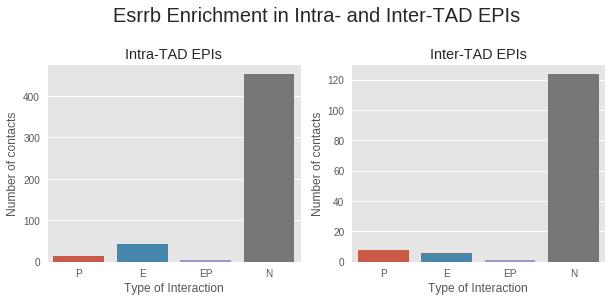

In [538]:
plt.figure(figsize=[10,8])
plt.subplot(221)

ax1 = sns.countplot(x="ep_status", data=intra_ep, order=['P','E','EP','N']) # yerr=plot_ci
plt.xlabel('Type of Interaction')
plt.ylabel('Number of contacts')
plt.title('Intra-TAD EPIs')

plt.subplot(222)
ax2 = sns.countplot(x="ep_status", data=inter_ep, order=['P','E','EP','N'])
plt.xlabel('Type of Interaction')
plt.ylabel('Number of contacts')
plt.title('Inter-TAD EPIs')

plt.suptitle(chipname + ' Enrichment in Intra- and Inter-TAD EPIs',size=20)


# Save figure
# plt.savefig(chipname + '_sbs_narrowed.png')

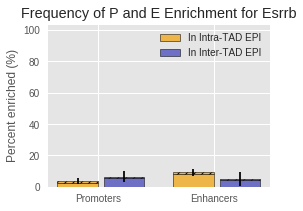

In [539]:
intra_means = (prob_P_intra*100, prob_E_intra*100)
intra_std = (plot_ci_intra[0]*100, plot_ci_intra[1]*100)

inter_means = (prob_P_inter*100, prob_E_inter*100)
inter_std = (plot_ci_inter[0]*100, plot_ci_inter[1]*100)

intra_EP_means = (prob_EP_intra*100, prob_EP_intra*100)
inter_EP_means = (prob_EP_inter*100, prob_EP_inter*100)

fig, ax = plt.subplots(figsize=[4,3])#figsize=[10,8])

ind = np.arange(2)    # the x locations for the groups
width = 0.35         # the width of the bars
p1 = ax.bar(ind, intra_means, width, color='#eeb549', bottom=0, edgecolor='black',)
p3 = ax.bar(ind, intra_EP_means, width, color='#eeb549', bottom=intra_means, yerr=intra_std, hatch="///", edgecolor='black')

p2 = ax.bar(ind + width+0.05, inter_means, width,  color='#6e70c5', bottom=0, edgecolor='black',)
p4 = ax.bar(ind+width+0.05, inter_EP_means, width, color='#6e70c5', bottom=inter_means, yerr=inter_std, hatch="///", edgecolor='black')

plt.ylabel('Percent enriched (%)') #, fontsize=16)
plt.ylim([0,104]) #, fontsize=16)

ax.set_title('Frequency of P and E Enrichment for ' + chipname) #, fontsize=20) 

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Promoters', 'Enhancers')) #, fontsize=16)

ax.legend((p1[0], p2[0]), ('In Intra-TAD EPI', 'In Inter-TAD EPI')) #, fontsize=16)

plt.show()
plt.savefig('figs/' + chipname + '_sbs_small.png')

In [540]:
# Maybe generate table from above numbers